In [1]:
from skimage import io
import pickle
import os
import numpy as np

def load_faces_and_eyes(dir_name = 'faces_imgs', eye_path = './eyes.pickle'):
       
    faces = dict()
    files = [(f, os.path.join(dir_name, f))  for f in os.listdir(dir_name)]
    for f, f_full in files:
        img = io.imread(f_full)
        faces[f] = img
        
    with open('./eyes.pickle', 'rb') as f:
        eyes = pickle.load(f)
        
    return faces, eyes
    
    
faces, eyes = load_faces_and_eyes()

In [2]:
face = faces['1.jpg']

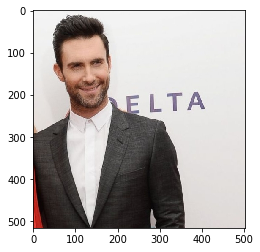

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(face)

In [4]:
eyes

{'2.jpg': [(108, 92), (145, 88)],
 '6.jpg': [(169, 133), (222, 126)],
 '4.jpg': [(146, 174), (211, 180)],
 '5.jpg': [(230, 121), (279, 114)],
 '3.jpg': [(173, 201), (246, 193)],
 '1.jpg': [(104, 132), (152, 124)]}

In [4]:
eye = eyes['1.jpg']

In [7]:
eye

[(104, 132), (152, 124)]

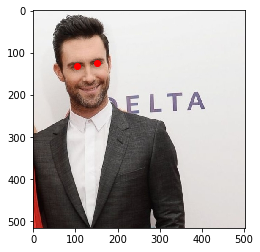

In [6]:
plt.plot(eye[0][0], eye[0][1], 'ro')
plt.plot(eye[1][0], eye[1][1], 'ro')
plt.imshow(face)

In [10]:
"""
1.找到眼睛倾斜的角度和两眼距离
"""
p1 = np.array(eye[0])[::-1] # 左眼坐标
p2 = np.array(eye[1])[::-1] # 右眼坐标
dist = np.sqrt(np.sum(p1-p2)**2) # 两只眼睛之间的距离

In [11]:
p1

array([132, 104])

In [12]:
p2

array([124, 152])

In [13]:
dist

40.0

In [14]:
dp = p1 - p2

In [15]:
angle = np.arctan(dp[0] / dp[1])

In [16]:
angle

-0.16514867741462683

In [17]:
# 两眼距离的中点
org_eye_center = np.array((p1 + p2) / 2, dtype=np.int)
# 图像的中点
org_image_center = np.array((np.array(face.shape[:2]) - 1) / 2, dtype=np.int)

In [18]:
org_eye_center

array([128, 128])

In [19]:
org_image_center

array([257, 251])

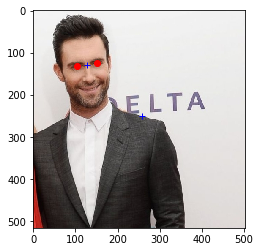

In [25]:
plt.plot(eye[0][0], eye[0][1], 'ro')
plt.plot(eye[1][0], eye[1][1], 'ro')
plt.plot(org_eye_center[0], org_eye_center[1], 'b+')
plt.plot(org_image_center[0], org_image_center[1], 'b+')
plt.imshow(face)

In [28]:
"""
2. 旋转图片
"""
from scipy import ndimage

# angle = angle，如果 angle < 0 则为 angle = 180 + angle
rot_img = ndimage.rotate(face, angle=+angle*180/np.pi)

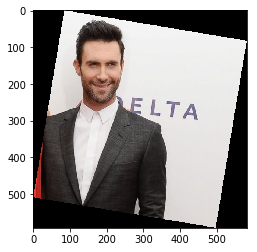

In [29]:
plt.imshow(rot_img)

In [30]:
# 旋转后图像的中点
rot_image_center = np.array((np.array(rot_img.shape[:2]) - 1) / 2, dtype=np.int)

In [31]:
rot_image_center

array([295, 290])

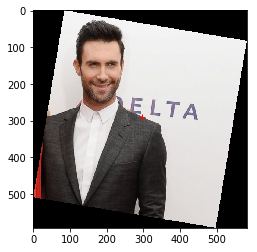

In [33]:
plt.plot(rot_image_center[0], rot_image_center[1], 'r+')
plt.imshow(rot_img)

In [34]:
"""
3. 在旋转后的图片中找到眼睛的坐标
"""
# 以图片中心进行旋转
# 在旋转后的图片中找到眼睛的中点
R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
rot_eye_center = np.dot(R, org_eye_center[::-1]-org_image_center[::-1])[::-1] + rot_image_center
rot_eye_center = np.array(rot_eye_center, dtype=int)

In [35]:
rot_eye_center

array([147, 189])

In [36]:
rot_img.shape

(592, 582, 3)

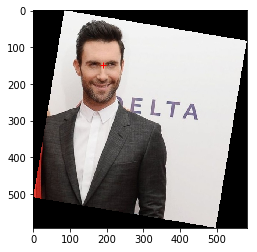

In [58]:
plt.plot(rot_eye_center[1], rot_eye_center[0], 'r+')
plt.imshow(rot_img)

In [40]:
mid_y, mid_x = rot_eye_center

In [41]:
mid_y

147

In [42]:
mid_x

189

In [43]:
MUL = 2
y_top = int(max(mid_y - MUL * dist, 0))

In [44]:
y_top

67

In [45]:
y_bot = int(min(mid_y + MUL * dist, rot_img.shape[0]))

In [46]:
y_bot

227

In [47]:
x_left = int(max(mid_x - MUL * dist, 0))
x_right = int(min(mid_x + MUL * dist, rot_img.shape[1]))

In [48]:
x_left

109

In [49]:
"""
4. 根据眼睛坐标找到包含面部的框的宽度和高度
"""
mid_y, mid_x = rot_eye_center
    
MUL = 2
y_top = int(max(mid_y - MUL * dist, 0))
y_bot = int(min(mid_y + MUL * dist, rot_img.shape[0]))
x_left = int(max(mid_x - MUL * dist, 0))
x_right = int(min(mid_x + MUL * dist, rot_img.shape[1]))
    
cropped_img = rot_img[y_top:y_bot+1, x_left:x_right+1, :]

In [50]:
cropped_img.shape

(161, 161, 3)

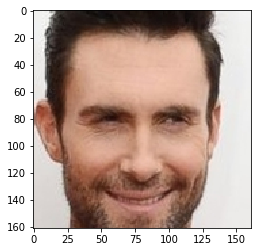

In [62]:
plt.imshow(cropped_img)

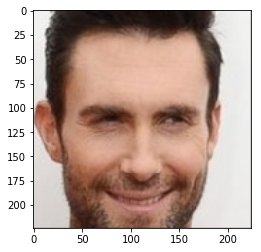

In [60]:
"""
5. 裁剪图像的尺寸为 224x224
"""
import skimage.transform as transform

scaled_img = transform.resize(cropped_img, [224, 224], mode='constant')
plt.imshow(scaled_img)